In [1]:
import os
import os.path as osp
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

import kagglehub
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from torchvision.models import resnet50

from tqdm import tqdm  # For progress bar


# Define the colour map from the provided colour map file
colour_map = {
    (0, 0, 0): 0,           # void
    (108, 64, 20): 1,       # dirt
    (255, 229, 204): 2,     # sand
    (0, 102, 0): 3,         # grass
    (0, 255, 0): 4,         # tree
    (0, 153, 153): 5,       # pole
    (0, 128, 255): 6,       # water
    (0, 0, 255): 7,         # sky
    (255, 255, 0): 8,       # vehicle
    (255, 0, 127): 9,       # container/generic-object
    (64, 64, 64): 10,       # asphalt
    (255, 128, 0): 11,      # gravel
    (255, 0, 0): 12,        # building
    (153, 76, 0): 13,       # mulch
    (102, 102, 0): 14,      # rock-bed
    (102, 0, 0): 15,        # log
    (0, 255, 128): 16,      # bicycle
    (204, 153, 255): 17,    # person
    (102, 0, 204): 18,      # fence
    (255, 153, 204): 19,    # bush
    (0, 102, 102): 20,      # sign
    (153, 204, 255): 21,    # rock
    (102, 255, 255): 22,    # bridge
    (101, 101, 11): 23,     # concrete
    (114, 85, 47): 24       # picnic-table
}
 
class_mapping = {
    0: 0,  # void -> void
    1: 1,  # dirt -> navigable
    2: 1,  # sand -> navigable
    3: 1,  # grass -> navigable
    4: 2,  # tree -> obstacle
    5: 2,  # pole -> obstacle
    6: 3,  # water -> non-navigable
    7: 0,  # sky -> void
    8: 2,  # vehicle -> obstacle
    9: 2,  # container -> obstacle
    10: 1,  # asphalt -> navigable
    11: 1,  # gravel -> navigable
    12: 2,  # building -> obstacle
    13: 1,  # mulch -> navigable
    14: 1,  # rock bed -> navigable
    15: 2,  # log -> obstacle
    16: 2,  # bicycle -> obstacle
    17: 2,  # person -> obstacle
    18: 2,  # fence -> obstacle
    19: 2,  # bush -> obstacle
    20: 0,  # sign -> void
    21: 1,  # rock -> navigable
    22: 2,  # bridge -> obstacle
    23: 1,  # concrete -> navigable
    24: 2   # picnic table -> obstacle
}
num_classes =4


In [ ]:

"""
class RUGDDataset(Dataset):
    def __init__(self, image_dir, annotation_dir, split='train', transform=None, mask_transform=None, mask_suffix="_group4.png"):
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.split = split
        self.transform = transform
        self.mask_transform = mask_transform
        self.mask_suffix = mask_suffix
 
        # Validate directories
        if not os.path.exists(self.image_dir) or not os.path.exists(self.annotation_dir):
            raise FileNotFoundError(f"Image or annotation directory not found: {self.image_dir}, {self.annotation_dir}")
 
        # Define which sequences to use based on the split
        if self.split == 'train':
            self.sequences = ['park-2', 'park-8', 'creek', 'trail', 'trail-3', 'trail-4', 'trail-9', 'trail-10', 'trail-11', 'trail-12', 'trail-14', 'trail-15', 'village']
        elif self.split == 'val':
            self.sequences = ['trail-6', 'trail-5']
        elif self.split == 'test':
            self.sequences = ['park-1', 'trail-7', 'trail-13']
        else:
            raise ValueError(f"Invalid split name: {self.split}. Must be 'train', 'val', or 'test'.")
 
        # Retrieve image and annotation paths
        self.image_paths, self.annotation_paths = self._get_paths()
        # Validate dataset size
        if len(self.image_paths) == 0 or len(self.annotation_paths) == 0:
            raise ValueError(f"No matching images or annotations found in the {self.split} split.")
 
    def _get_paths(self):
        #Helper function to retrieve paths for images and annotations.
        image_paths = []
        annotation_paths = []
        valid_extensions = {".png", ".jpg", ".jpeg", ".tif", ".bmp"}
        for seq in self.sequences:
            img_seq_dir = os.path.join(self.image_dir, seq)
            ann_seq_dir = os.path.join(self.annotation_dir, seq)
            if not os.path.exists(img_seq_dir) or not os.path.exists(ann_seq_dir):
                print(f"Skipping sequence {seq}: directory not found.")
                continue
 
            # Get valid image and annotation files
    
            #print("img_seq_dir: ",img_seq_dir)
            #print("ann_seq_dir: ",ann_seq_dir)
            print("image folders: ",os.listdir('C:/Users/dalva/GANav-offroad/data/rugd/RUGD_frames-with-annotations'))
            print("annotation folders: ",os.listdir('C:/Users/dalva/GANav-offroad/data/rugd/RUGD_annotations/'))
            
            img_files = {f for f in os.listdir(img_seq_dir) if os.path.splitext(f)[-1].lower() in valid_extensions}
            ann_files = {f for f in os.listdir(ann_seq_dir) if f.endswith(self.mask_suffix)}
            
            for f in os.listdir(ann_seq_dir):
               # print(f)
                debug_file_ext = os.path.splitext(f)[-1].lower()
              #  print("os.path.splitext(f)[-1].lower(): ",debug_file_ext)
                if debug_file_ext in valid_extensions:
                #    print("should pass file extension check")
                    pass
                if f.endswith(self.mask_suffix):
                 #   print("passed endsWith check.")
                    pass
                
            #print("\nimg_files: ", img_files )
            #print("\nann_files: ", ann_files )
            # Match files by name
            common_files = img_files.intersection(ann_files)
            
            print("common files: ", common_files)
            
            
            for file_name in sorted(common_files):
                image_paths.append(os.path.join(img_seq_dir, file_name))
                annotation_paths.append(os.path.join(ann_seq_dir, file_name))
        return image_paths, annotation_paths
 
    def __len__(self):
        return len(self.image_paths)
 
    def __getitem__(self, idx):
        # Load image and mask
        image = Image.open(self.image_paths[idx]).convert('RGB')
        annotation = Image.open(self.annotation_paths[idx]).convert('L')  # Grayscale mask for reduced classes
 
        # Apply transformations
        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            annotation = self.mask_transform(annotation)
 
        # Convert annotation to tensor
        annotation = torch.from_numpy(np.array(annotation, dtype=np.int64))
 
        return image, annotation
"""; 

In [2]:
class RUGDDataset(Dataset):
    def __init__(self, image_dir, annotation_dir, split='train', transform=None, mask_transform=None, mask_suffix="_group4.png", split_file_dir=None):
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.split = split
        self.transform = transform
        self.mask_transform = mask_transform
        self.mask_suffix = mask_suffix
        self.split_file_dir = split_file_dir
 
        # Validate directories
        if not os.path.exists(self.image_dir) or not os.path.exists(self.annotation_dir):
            raise FileNotFoundError(f"Image or annotation directory not found: {self.image_dir}, {self.annotation_dir}")
 
        # Load sequences from split files if provided
        self.sequences = self._load_sequences()
 
        # Retrieve image and annotation paths
        self.image_paths, self.annotation_paths = self._get_paths()
 
        # Validate dataset size
        if len(self.image_paths) == 0 or len(self.annotation_paths) == 0:
            raise ValueError(f"No matching images or annotations found in the {self.split} split.")
 
    def _load_sequences(self):
        """Load sequences from a split file or use defaults."""
        if self.split_file_dir:
            split_file_path = os.path.join(self.split_file_dir, f"{self.split}.txt")
            if not os.path.exists(split_file_path):
                raise FileNotFoundError(f"Split file not found: {split_file_path}")
            with open(split_file_path, 'r') as f:
                sequences = [line.strip() for line in f.readlines()]
            print(f"Loaded {len(sequences)} sequences from {split_file_path}.")
            return sequences
        else:
            # Default sequences if no split file is provided
            if self.split == 'train':
                return ['park-2', 'park-8', 'creek', 'trail', 'trail-3', 'trail-4', 'trail-9', 'trail-10', 'trail-11', 'trail-12', 'trail-14', 'trail-15', 'village']
            elif self.split == 'val':
                return ['trail-6', 'trail-5']
            elif self.split == 'test':
                return ['park-1', 'trail-7', 'trail-13']
            else:
                raise ValueError(f"Invalid split name: {self.split}. Must be 'train', 'val', or 'test'.")
 
    def _get_paths(self):
        """Helper function to retrieve paths for images and annotations."""
        image_paths = []
        annotation_paths = []
        valid_extensions = {".png", ".jpg", ".jpeg", ".tif", ".bmp"}
        for seq in self.sequences:
            img_seq_dir = os.path.join(self.image_dir, seq)
            ann_seq_dir = os.path.join(self.annotation_dir, seq)

            if not os.path.exists(img_seq_dir) or not os.path.exists(ann_seq_dir):
                print(f"Skipping sequence {seq}: directory not found.")
                continue

            # Get valid image and annotation files
            img_files = {os.path.splitext(f)[0] for f in os.listdir(img_seq_dir) if os.path.splitext(f)[-1].lower() in valid_extensions}
            ann_files = {os.path.splitext(f)[0].replace(self.mask_suffix.split('.')[0], '') for f in os.listdir(ann_seq_dir) if f.endswith(self.mask_suffix)}

            # Match files by name
            common_files = img_files.intersection(ann_files)
            print(f"Found {len(common_files)} matching files in sequence '{seq}'.")

            for file_name in sorted(common_files):
                image_paths.append(os.path.join(img_seq_dir, file_name + ".png"))  # Add extension if necessary
                annotation_paths.append(os.path.join(ann_seq_dir, file_name + self.mask_suffix))

        return image_paths, annotation_paths

 
    def __len__(self):
        return len(self.image_paths)
 
    def __getitem__(self, idx):
        # Load image and mask
        image = Image.open(self.image_paths[idx]).convert('RGB')
        annotation = Image.open(self.annotation_paths[idx]).convert('L')  # Grayscale mask for reduced classes
 
        # Apply transformations
        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            annotation = self.mask_transform(annotation)
 
        # Convert annotation to tensor
        annotation = torch.from_numpy(np.array(annotation, dtype=np.int64))
        return image, annotation


In [5]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Define mask transformation to resize to 256x256
mask_transform = transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST)

# Load datasets
train_dataset = RUGDDataset(
    image_dir = 'C:/Users/dalva/GANav-offroad/data/rugd/RUGD_frames-with-annotations/',
    annotation_dir='C:/Users/dalva/GANav-offroad/data/rugd/RUGD_annotations/',
    split='train',
    transform=transform,
    mask_transform=mask_transform
)

val_dataset = RUGDDataset(
    #image_dir='/root/.cache/kagglehub/datasets/shivamguptakaggle/rugd-terrain-recognition/versions/1/RUGD/RUGD_frames-with-annotations/RUGD_frames-with-annotations',
    #annotation_dir='/root/.cache/kagglehub/datasets/shivamguptakaggle/rugd-terrain-recognition/versions/1/RUGD/RUGD_annotations/RUGD_annotations',
    image_dir= 'C:/Users/dalva/GANav-offroad/data/rugd/RUGD_frames-with-annotations/',
    annotation_dir='C:/Users/dalva/GANav-offroad/data/rugd/RUGD_annotations/',
    split='val',
    transform=transform,
    mask_transform=mask_transform
)

test_dataset = RUGDDataset(
    #image_dir='/root/.cache/kagglehub/datasets/shivamguptakaggle/rugd-terrain-recognition/versions/1/RUGD/RUGD_frames-with-annotations/RUGD_frames-with-annotations',
    #annotation_dir='/root/.cache/kagglehub/datasets/shivamguptakaggle/rugd-terrain-recognition/versions/1/RUGD/RUGD_annotations/RUGD_annotations',
    image_dir= 'C:/Users/dalva/GANav-offroad/data/rugd/RUGD_frames-with-annotations/',
    annotation_dir='C:/Users/dalva/GANav-offroad/data/rugd/RUGD_annotations/',
    split='test',
    transform=transform,
    mask_transform=mask_transform
)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

###### DEBUG FLAG##################
debug_labels = []

#train_features, train_labels = next(iter(train_dataloader))
#for images, labels in train_loader:
 #   debug_labels.extend(labels.tolist())
   # print("labels[0]: ",labels)
   # debug_in = input("pause")
#print("debug_labels[:100]: ",debug_labels[:100])
#for _, label in train_loader:
#    for i in label:
#        for j in i:
            #debug_labels.append(j[0].item()))
 #           print(j)
 #           print("linebreak")
 #   debug_labels.append(label.item())  # Collect labels into a list


Found 656 matching files in sequence 'park-2'.
Found 357 matching files in sequence 'park-8'.
Found 836 matching files in sequence 'creek'.
Found 693 matching files in sequence 'trail'.
Found 580 matching files in sequence 'trail-3'.
Found 758 matching files in sequence 'trail-4'.
Found 59 matching files in sequence 'trail-9'.
Found 49 matching files in sequence 'trail-10'.
Found 438 matching files in sequence 'trail-11'.
Found 352 matching files in sequence 'trail-12'.
Found 314 matching files in sequence 'trail-14'.
Found 324 matching files in sequence 'trail-15'.
Found 117 matching files in sequence 'village'.
Found 439 matching files in sequence 'trail-6'.
Found 376 matching files in sequence 'trail-5'.
Found 627 matching files in sequence 'park-1'.
Found 289 matching files in sequence 'trail-7'.
Found 172 matching files in sequence 'trail-13'.


In [ ]:
#print("count 0: ",debug_labels.count(0))
#print("count 1: ",debug_labels.count(1))
#print("count 2: ",debug_labels.count(2))
#print("count 3: ",debug_labels.count(3))
#print(debug_labels[0])

In [6]:
# Get a single batch from the train_loader
sample_batch = next(iter(train_loader))

# Separate the lists of images and masks
images, masks = sample_batch

# Print the shape of the entire batch
print("Batch size:", len(images))  # This should be 32 if batch_size=32

# Print the shape of the first image and mask in the batch
print("First image shape:", images[0].shape)
print("First mask shape:", masks[0].shape)

# Print the tensors of the first image and mask in the batch
print("First image tensor:", images[0])
print("First mask tensor:", masks[0])

Batch size: 32
First image shape: torch.Size([3, 256, 256])
First mask shape: torch.Size([256, 256])
First image tensor: tensor([[[-1.8439, -1.7925, -1.6727,  ..., -1.5357, -1.4672, -1.3987],
         [-1.8439, -1.7583, -1.6213,  ..., -1.5528, -1.4500, -1.4843],
         [-1.8439, -1.8097, -1.8268,  ..., -1.1075, -0.4397, -0.0629],
         ...,
         [-1.6042, -1.5357, -1.5185,  ..., -1.2103, -1.2274, -1.2103],
         [-1.5528, -1.5357, -1.5185,  ..., -1.2103, -1.2445, -1.2445],
         [-1.5528, -1.5528, -1.5357,  ..., -1.2445, -1.2788, -1.2959]],

        [[-1.7381, -1.6681, -1.5280,  ..., -1.4055, -1.3004, -1.2479],
         [-1.7206, -1.6331, -1.4930,  ..., -1.4055, -1.2479, -1.2654],
         [-1.7206, -1.7031, -1.7031,  ..., -0.9678, -0.1975,  0.2752],
         ...,
         [-1.4405, -1.3529, -1.3179,  ..., -1.0378, -1.0378, -1.0553],
         [-1.4230, -1.3529, -1.3529,  ..., -1.0028, -1.0378, -1.0553],
         [-1.4230, -1.3704, -1.3880,  ..., -1.0203, -1.0553, -1.1078

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


cmap_colors:  [(0, 0, 0), (108, 64, 20), (255, 229, 204), (0, 102, 0), (0, 255, 0), (0, 153, 153), (0, 128, 255), (0, 0, 255), (255, 255, 0), (255, 0, 127), (64, 64, 64), (255, 128, 0), (255, 0, 0), (153, 76, 0), (102, 102, 0), (102, 0, 0), (0, 255, 128), (204, 153, 255), (102, 0, 204), (255, 153, 204), (0, 102, 102), (153, 204, 255), (102, 255, 255), (101, 101, 11), (114, 85, 47)]


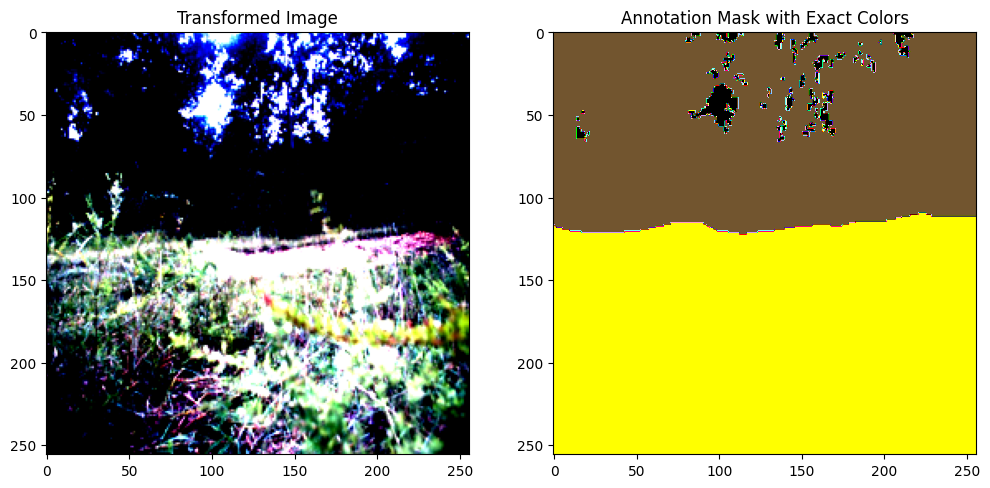

In [7]:

# Reverse the colour_map to get {class_index: RGB_tuple}
index_to_rgb = {v: k for k, v in colour_map.items()}

########## DEBUG SECTION ########################
#print("index_to_rgb:\n")
#print(index_to_rgb)
#print("\n\n")
#for i,j in colour_map.items():
#    print(f"k: {i},  v: {j}")
#debug_flag = input("pausing")
########## DEBUG SECTION END ########################
    
    
# Create a list of colors where the index corresponds to the class
num_classes = max(index_to_rgb.keys()) + 1  # Number of classes
cmap_colors = [index_to_rgb[i] if i in index_to_rgb else (0, 0, 0) for i in range(num_classes)]
print("cmap_colors: ",cmap_colors)
cmap_colors = np.array(cmap_colors) / 255.0  # Normalize RGB values to [0, 1] for matplotlib
# Create a ListedColormap with these colors
cmap = ListedColormap(cmap_colors)
# Display the transformed image and its corresponding mask
plt.figure(figsize=(12, 6))

# Display the image
plt.subplot(1, 2, 1)
plt.imshow(images[0].permute(1, 2, 0).numpy())
plt.title("Transformed Image")

# Display the mask with the exact color mapping
plt.subplot(1, 2, 2)
plt.imshow(masks[0].numpy(), cmap=cmap)
plt.title("Annotation Mask with Exact Colors")

plt.show()

In [8]:

# Attention Gate
class AttentionGate(nn.Module):
    def __init__(self, in_channels, gating_channels, inter_channels):
        super(AttentionGate, self).__init__()
        self.Wx = nn.Sequential(
            nn.Conv2d(in_channels, inter_channels, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(inter_channels)
        )
        self.Wg = nn.Sequential(
            nn.Conv2d(gating_channels, inter_channels, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(inter_channels)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(inter_channels, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x, g):
        # Process skip connection and gating signal
        g1 = self.Wg(g)
        x1 = self.Wx(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi  # Refine skip connection

# Decoder Block with Attention
class DecoderBlockWithAttention(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super(DecoderBlockWithAttention, self).__init__()
        self.attention_gate = AttentionGate(skip_channels, in_channels, inter_channels=out_channels)
        self.upsample = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

        self.conv1 = nn.Sequential(
            nn.Conv2d(out_channels + skip_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, skip):
        # Apply attention gate
        refined_skip = self.attention_gate(skip, x)

        # Upsample and concatenate
        x = self.upsample(x)
        x = torch.cat([x, refined_skip], dim=1)

        # Apply convolutions
        x = self.conv1(x)
        x = self.conv2(x)

        return x

# Atrous Spatial Pyramid Pooling (ASPP)
class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels, rates=[6, 12, 18, 24]):
        super(ASPP, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=rates[0], dilation=rates[0]),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=rates[1], dilation=rates[1]),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=rates[2], dilation=rates[2]),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=rates[3], dilation=rates[3]),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.pool_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

        self.final_conv = nn.Sequential(
            nn.Conv2d(out_channels * 6, out_channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x)
        x3 = self.conv3(x)
        x4 = self.conv4(x)
        x5 = self.conv5(x)

        # Global pooling
        x6 = self.global_pool(x)
        x6 = self.pool_conv(x6)
        x6 = F.interpolate(x6, size=x.shape[2:], mode='bilinear', align_corners=False)

        # Concatenate all outputs
        x = torch.cat([x1, x2, x3, x4, x5, x6], dim=1)

        # Final convolution
        x = self.final_conv(x)
        return x

# Main Model: ResNetUNetASPPWithAttention
class ResNetUNetASPPWithAttention(nn.Module):
    def __init__(self, out_channels=256, num_classes=25):
        super(ResNetUNetASPPWithAttention, self).__init__()

        # Load the ResNet encoder and remove the fully connected layer
        resnet = resnet50(pretrained=True)
        self.encoder_layers = nn.ModuleList(list(resnet.children())[:-2])  # Remove FC and avg pool layers

        # Define ASPP module for extracting multi-scale context
        self.aspp = ASPP(in_channels=2048, out_channels=out_channels)

        # Define U-Net decoder blocks with attention gates
        self.decoder4 = DecoderBlockWithAttention(out_channels, 1024, 256)
        self.decoder3 = DecoderBlockWithAttention(256, 512, 128)
        self.decoder2 = DecoderBlockWithAttention(128, 256, 64)
        self.decoder1 = DecoderBlockWithAttention(64, 64, 32)

        # Final classification layer
        self.classifier = nn.Conv2d(32, num_classes, kernel_size=1)

    def forward(self, x):
        # Encoder: Extract features and collect skip connections
        skip_connections = []
        for i, layer in enumerate(self.encoder_layers):
            x = layer(x)
            if i in [4, 5, 6, 7]:  # Save skip connections from ResNet stages
                skip_connections.append(x)

        # Reverse the skip connections for decoding
        skip_connections = skip_connections[::-1]

        # ASPP: Apply atrous spatial pyramid pooling
        x = self.aspp(x)

        # Decoder: Apply Attention U-Net blocks with skip connections
        x = self.decoder4(x, skip_connections[0])  # Stage 4
        x = self.decoder3(x, skip_connections[1])  # Stage 3
        x = self.decoder2(x, skip_connections[2])  # Stage 2
        x = self.decoder1(x, skip_connections[3])  # Stage 1

        # Final classification layer
        x = self.classifier(x)

        # Upsample to the input image size
        x = F.interpolate(x, scale_factor=4, mode='bilinear', align_corners=False)
        return x


In [9]:
model = ResNetUNetASPPWithAttention(out_channels=256, num_classes=4)

In [17]:
##### DEBUG FLAG: ATTEMPT TO GET CLASS WEIGHTS
from sklearn.utils import class_weight
from collections import Counter
import random 

all_labels = []
#for _, mask in tqdm(train_dataset, desc="Processing Masks"):
#    all_labels.append(mask.flatten().numpy())
class_counts = Counter()

subset_size = 300  # Adjust the size of the subset
subset_indices = random.sample(range(len(train_dataset)), subset_size)

for idx in tqdm(subset_indices, desc="Processing Subset"):
    _, mask = train_dataset[idx]
    flat_mask = mask.flatten().numpy()  # Flatten the mask
    class_counts.update(flat_mask) 

all_labels = np.array(list(class_counts.elements())) 
#all_labels = np.concatenate(all_labels)

output = set()
for x in all_labels:
    output.add(x)
print(output)


print("len(all_labels: ", len(all_labels), ",  all_labels: ",all_labels)

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',  # Can be 'balanced' or you can manually specify weights
    classes=np.arange(num_classes), 
    y=all_labels
)

print(class_weights)

Processing Subset: 100%|█████████████████████████████████████████████████████████████| 300/300 [00:06<00:00, 46.43it/s]


len(all_labels:  19660800 ,  all_labels:  [0 0 0 ... 2 2 2]


ValueError: classes should have valid labels that are in y

In [93]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the chosen device
model = model.to(device)

# Define optimizer, loss function, and scheduler

#class_weights = torch.tensor(class_weights, dtype=torch.float, device=device)  # Class weights

optimizer = optim.Adam(model.parameters(), lr=0.001)

#criterion = nn.CrossEntropyLoss(weight=class_weights)

################ DEBUG FLAG START ###################
#class_weights = torch.tensor(class_weights, dtype=torch.float, device=device)  # Class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)
#criterion = nn.CrossEntropyLoss()
################ DEBUG FLAG END ###################

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

# Attempt to load checkpoint
try:
    checkpoint = torch.load('best_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    min_val_loss = checkpoint['min_val_loss']
    print("Resuming training from saved model...")
except FileNotFoundError:
    min_val_loss = float('inf')
    print("'best_model.pth' not found. Starting training from scratch...")

# Training parameters
num_epochs = 50
patience = 7
not_improve_count = 0
early_stop = False

# Dice Score function
def dice_score(pred, target):
    pred = torch.argmax(pred, dim=1)  # Convert logits to class predictions
    smooth = 1e-6
    intersection = (pred * target).sum()
    return (2.0 * intersection + smooth) / (pred.sum() + target.sum() + smooth)

# Training loop
for epoch in range(num_epochs):
    if early_stop:
        break

    model.train()
    epoch_loss = 0

    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()

        # Track training loss
        epoch_loss += loss.item()

    # Calculate average training loss
    avg_train_loss = epoch_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}")

    # Validation step
    model.eval()
    val_loss = 0
    dice = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
            dice += dice_score(outputs, masks).item()

    avg_val_loss = val_loss / len(val_loader)
    avg_dice_score = dice / len(val_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}, Dice Score: {avg_dice_score:.4f}")

    # Adjust learning rate
    scheduler.step(avg_val_loss)

    # Early stopping and checkpoint saving
    if avg_val_loss < min_val_loss:
        min_val_loss = avg_val_loss
        not_improve_count = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'min_val_loss': min_val_loss,
        }, 'best_model.pth')
        print(f"Validation loss decreased to {min_val_loss:.4f}, saving model.")
    else:
        not_improve_count += 1
        print(f"Loss did not decrease for {not_improve_count} time(s)")
        if not_improve_count >= patience:
            print(f"Early stopping triggered after {patience} epochs without improvement.")
            early_stop = True

# Load the best model
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print("Loaded best model based on validation loss.")


'best_model.pth' not found. Starting training from scratch...


Epoch 1/50:   0%|                                                                              | 0/173 [00:02<?, ?it/s]


RuntimeError: Given groups=1, weight of size [256, 1024, 1, 1], expected input[32, 2048, 8, 8] to have 1024 channels, but got 2048 channels instead

Counting pixels in datasets...
Train class counts: [ 27035947 161753667   1493439 172327635         0         0         0
         0         0         0         0         0         0         0
         0         0         0         0         0         0         0
         0         0         0         0]
Validation class counts: [ 3402234 24706964    42305 25260337        0        0        0        0
        0        0        0        0        0        0        0        0
        0        0        0        0        0        0        0        0
        0]
Test class counts: [ 7441787 31290476     3830 32567075        0        0        0        0
        0        0        0        0        0        0        0        0
        0        0        0        0        0        0        0        0
        0]


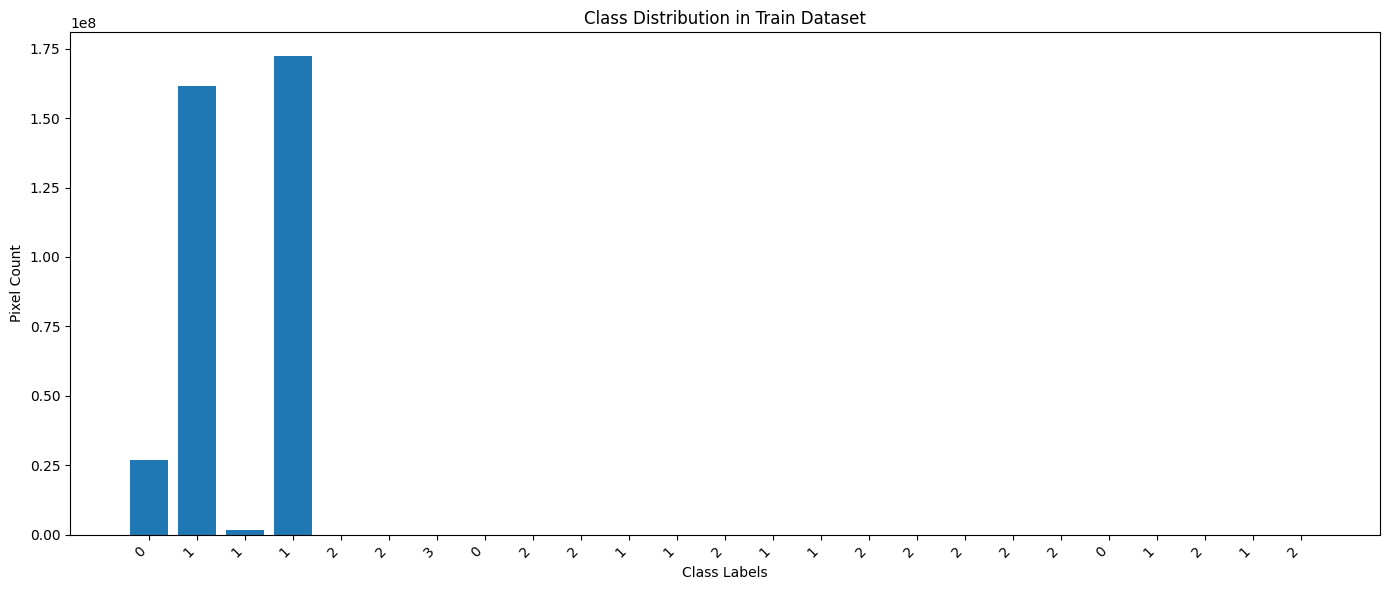

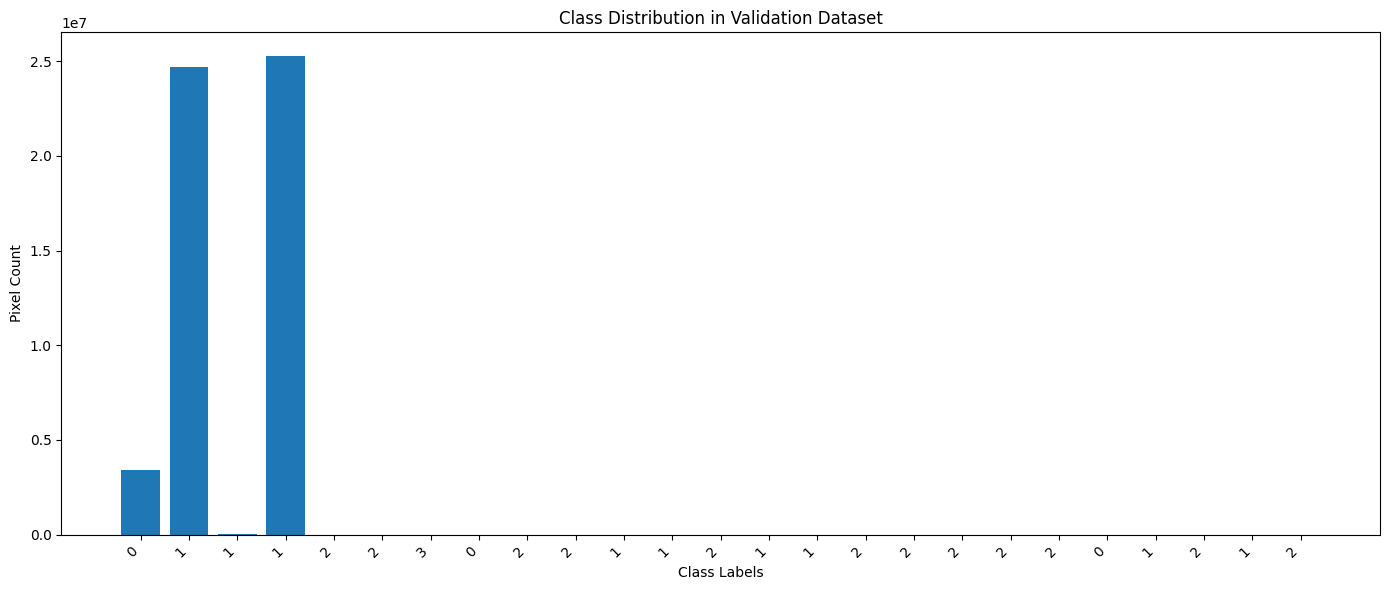

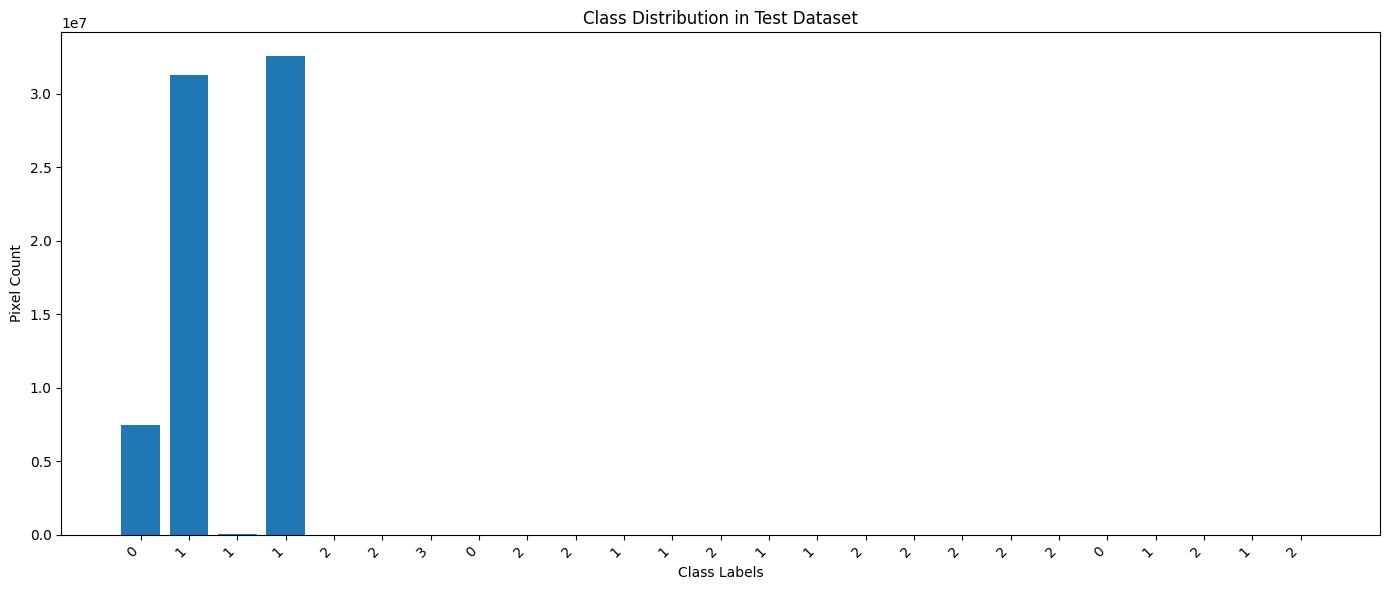

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
 
# Function to count pixels for each class
def count_class_pixels(loader, num_classes):
    class_counts = np.zeros(num_classes, dtype=np.int64)
 
    for _, masks in loader:
        masks = masks.detach().cpu().numpy()  # Convert masks to NumPy arrays
        unique, counts = np.unique(masks, return_counts=True)
        valid_indices = unique < num_classes  # Ignore out-of-range class values
        class_counts[unique[valid_indices]] += counts[valid_indices]
    return class_counts
 
# Count pixels for train, validation, and test datasets
print("Counting pixels in datasets...")
datasets = [("Train", train_loader), ("Validation", val_loader), ("Test", test_loader)]
class_counts = {}
 
for name, loader in datasets:
    class_counts[name] = count_class_pixels(loader, num_classes)
    print(f"{name} class counts: {class_counts[name]}")
 
# Function to plot class distribution
def plot_class_distribution(class_counts, dataset_name, class_map):
    plt.figure(figsize=(14, 6))
    class_labels = [class_map[i] for i in range(len(class_counts))]
    plt.bar(range(len(class_counts)), class_counts, tick_label=class_labels)
    plt.xlabel('Class Labels')
    plt.ylabel('Pixel Count')
    plt.title(f'Class Distribution in {dataset_name} Dataset')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
 
# Plot distributions
for name, counts in class_counts.items():
    plot_class_distribution(counts, name, class_mapping)
 